# NLP: Natural Language Processing
## by Rebecca Hinrichs
### 3 Apr 2022

# Data Collection

In [56]:
# for data management & visualization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
# for machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
# for NLP
import nltk
#nltk.download()
from nltk.corpus import stopwords
import string
import tensorflow as tf
from tensorflow.keras.models import Sequential
# suppress version deprication warnings
import warnings
#warnings.filterwarnings('ignore')

In [3]:
# read in the data & set to dataframe called 'yelp1'
yelp1 = pd.read_csv('yelp.csv')

In [4]:
# check the head, info, and describe methods of yelp1
yelp1.head()
yelp1.info()
yelp1.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  10000 non-null  object
 1   date         10000 non-null  object
 2   review_id    10000 non-null  object
 3   stars        10000 non-null  int64 
 4   text         10000 non-null  object
 5   type         10000 non-null  object
 6   user_id      10000 non-null  object
 7   cool         10000 non-null  int64 
 8   useful       10000 non-null  int64 
 9   funny        10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


In [46]:
# create a new column called 'text length' which is the number of characters in the text column
yelp1['text length'] = yelp1['text'].apply(len)
yelp1['text length'].describe()

count    10000.000000
mean       710.738700
std        617.399827
min          1.000000
25%        294.000000
50%        541.500000
75%        930.000000
max       4997.000000
Name: text length, dtype: float64

# EDA

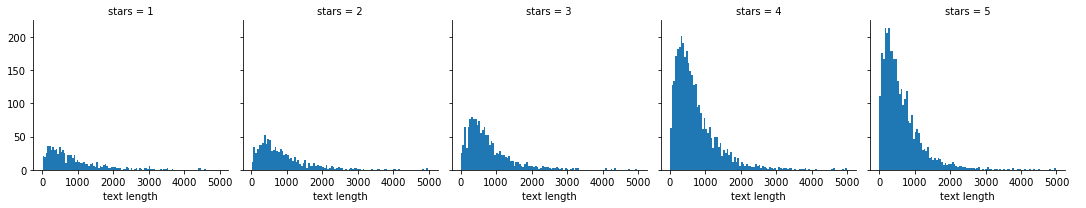

In [10]:
# use FacetGrid from the seaborn library to create a grid of 5 histograms 
# of text length based on the star ratings
# Note: since we have min=1 to max=~5k, I fine-tuned the data viz into bins=100
textlen = sns.FacetGrid(yelp1, col='stars', palette='mako')
textlen.map(plt.hist, 'text length', bins=100).add_legend()

<AxesSubplot:xlabel='stars', ylabel='text length'>

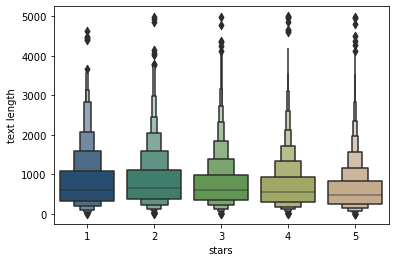

In [13]:
# create a boxplot of text length for each star category... going to do a boxenplot cuz it's a big set
sns.boxenplot(data=yelp1, x='stars', y='text length', palette='gist_earth')

<AxesSubplot:xlabel='stars', ylabel='count'>

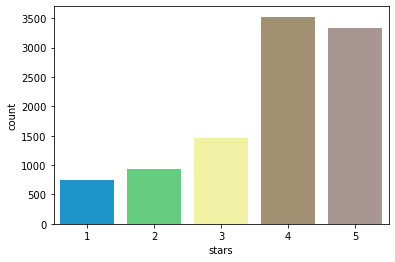

In [14]:
# create a countplot of the number of occurrences for each type of star rating
sns.countplot(data=yelp1, x='stars', palette='terrain')

In [15]:
# use groupby to get the mean values of the numerical columns
gstars = yelp1.groupby('stars').mean()
gstars.head(5)

,cool,useful,funny,text length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


In [16]:
# use the corr() method on that groupby dataframe obtained above to produce a correlation dataframe
cstars = gstars.corr()

<AxesSubplot:>

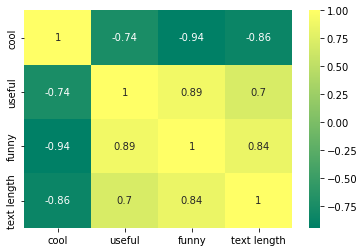

In [17]:
# now use seaborn to create a heatmap based on the .corr() dataframe you created above
sns.heatmap(cstars, cmap='summer', annot=True)

# NLP Classification

In [112]:
# first, grab reviews that were either 1 star or 5 stars. Then create a dataframe called yelp_class
# that contains the columns of yelp dataframe but for only the 1 or 5 star reviews
yelp_class = yelp1[(yelp1['stars'] == 1) | (yelp1['stars'] == 5)]
yelp_class['stars'].value_counts()

5    3337
1     749
Name: stars, dtype: int64

In [113]:
# create two objects X and y. X will be the 'text' column of yelp_class and y will be the 'stars' 
# column of yelp_class. (Thus features and labels)
X = yelp_class['text'].values  # features
y = yelp_class['stars'].values  # labels
print(f'There are ',X.shape[0],' features and ',y.shape[0],' labels.')

There are  4086  features and  4086  labels.


In [114]:
# import CountVectorizer and create a CountVectorizer object
bow_transformer = CountVectorizer().fit(yelp1['text'])
print(f'There are ',len(bow_transformer.vocabulary_),' characters.')

There are  29185  characters.


In [94]:
# use the fit_transform method on the CountVectorizer object and pass in X (the 'text' column).
# Save the result by overwriting X.
X = bow_transformer.fit_transform(X)

In [95]:
# use train_test_split to split up the data into X_train, X_test, y_train, y_test.
# Use test_size = 0.3 and random_state = 50
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

In [96]:
# import MultinomialNB and create an instance of the estimator and call as nb
nb = MultinomialNB()

In [97]:
# now fit nb using the training data
nb.fit(X_train, y_train)

MultinomialNB()

### Predictions & Evaluations

In [98]:
# use the predict method on nb to predict labels from X_test
all_predictions = nb.predict(X_test)
all_predictions

array([5, 5, 5, ..., 5, 5, 1], dtype=int64)

In [99]:
# create a confusion matrix and classification report using these predictions and y_test
print(f'Confusion Matrix:\n',confusion_matrix(y_test, all_predictions))
print()
print(f'Classification Report:\n',classification_report(y_test, all_predictions))

Confusion Matrix:
 [[151  76]
 [ 28 971]]

Classification Report:
               precision    recall  f1-score   support

           1       0.84      0.67      0.74       227
           5       0.93      0.97      0.95       999

    accuracy                           0.92      1226
   macro avg       0.89      0.82      0.85      1226
weighted avg       0.91      0.92      0.91      1226



In [ ]:
# now include TF-IDF to this process using a pipeline...........

# Text Processing

In [101]:
# import Tfid/Transformer from sklearn
from sklearn.feature_extraction.text import TfidfTransformer

In [102]:
# import Pipeline from sklearn
from sklearn.pipeline import Pipeline

In [115]:
# create a pipeline with the following steps: CountVectorizer(), TfidfTransformer(), MultinomialNB()
def text_process(mes):
    """
    Takes in a string of text , then performs the following :
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopun = [char for char in mes if char not in string.punctuation]
    # Join the characters again to form the string .
    nopun = ''.join(nopun)
    # Now just remove any stopwords
    return [word for word in nopun.split() if word.lower() not in stopwords.words('english')]
yelpvec_bow = bow_transformer.transform(yelp1['text'])
tfidf_transformer = TfidfTransformer().fit(yelpvec_bow)
yelpvec_tfidf = tfidf_transformer.transform(yelpvec_bow)
## <----------------------------------------->
pipeline = Pipeline([
    ('yelpvec', CountVectorizer(analyzer=text_process)), #strings to token integer counts
    ('tfidf', TfidfTransformer()), # integer counts to weighted TF−IDF scores
    ('classifier', MultinomialNB()), # train on TF−IDF vectors w/ Naive Bayes
])

In [117]:
# time to use the pipeline! Remember this pipeline has all your pre-processing steps in it already,
# meaning that we will need to re-split the original data (Remember that we overwrote X as the 
# CountVectorized version). What we need is just the text.
char_detect_model = MultinomialNB().fit(X_train, y_train)

In [118]:
# redo the train test split on the yelp_class object
X = yelp_class['text'].values  # features
y = yelp_class['stars'].values  # labels
yelp_train, yelp_test, label_train, label_test = train_test_split(X, y, test_size=0.3)

In [119]:
# now fit the pipeline to the training data; remember you can't use the same training data as last 
# time because that data has already been vectorized. We need to pass in just the text and labels.
pipeline.fit(yelp_train, label_train)

Pipeline(steps=[('yelpvec',
                 CountVectorizer(analyzer=<function text_process at 0x00000282E1FAF0D0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [127]:
# now use the pipeline to predict from the X_test and create a classification report and confusion
# matrix. You should notice strange results.
pipe_predict = pipeline.predict(yelp_test)
print(f'Confusion Matrix:\n',confusion_matrix(label_test, pipe_predict))
print()
print(f'Classification Report:\n',classification_report(label_test, pipe_predict))

Confusion Matrix:
 [[  1 235]
 [  0 990]]

Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.00      0.01       236
           5       0.81      1.00      0.89       990

    accuracy                           0.81      1226
   macro avg       0.90      0.50      0.45      1226
weighted avg       0.85      0.81      0.72      1226



In [ ]:
# did Tf-Idf actually make things better or worse?

Precision and recall are both fantastic in our classification report for reviews of 1 and 5 stars respectively. However, our confusion matrix still appears out of sorts. It appears as though our prediction values are, if aligned with the classification report, supposed to be practically completely truly positive and truly negative in correctly predicting classifications. Well-trained!

***
...
***